In [55]:
###print graph
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import re
#set working directory

home = os.environ["HOME"]

os.chdir(f"{home}/tiniMLVM")


## read controller experiment logs

#delete lines non starting with a number
with open("./experiments/drift_experiment.log", "r") as f:
    text = f.read()

text = re.sub(r"^[^0-9].*\n", "", text, flags=re.MULTILINE)

#write the text back to the file
with open("./experiments/drift_experiment.log", "w") as f:
    f.write(text)

df_controller = pd.read_csv(
    "./experiments/drift_experiment.log", names=["timestamp", "log"],dtype={"timestamp": int, "log": str}
).dropna()

print(df_controller)

## read drift deploy logs

# get drift-deploy log file names

log_files = os.listdir("./experiments")

# read drift-deploy logs
df_drift_deploy = pd.DataFrame()

for log_file in log_files:
    if log_file.startswith("drift-deploy"):
        #get string text
        with open(f"./experiments/{log_file}", "r") as f:
            text = f.read()

        #if there is only one comma in a line delete the \n

        text = re.sub(r"(^[^,]*,[^,]*[^e])\n", r"\1", text, flags=re.MULTILINE)
        text = re.sub(r"(^[^,]*,[^,]*[^e])\n", r"\1", text, flags=re.MULTILINE)
        
        #delete the double spaces
        text = text.replace("  ", " ")


        #write the text back to the file
        with open(f"./experiments/{log_file}", "w") as f:
            f.write(text)
        
        df = pd.read_csv(
            f"./experiments/{log_file}",dtype={"timestamp": int, "p_value": str, "drift": bool}
        )
        df_drift_deploy = pd.concat([df_drift_deploy, df])

### for each list in p_value column convert to list and get max value
df_drift_deploy['p_value'] = df_drift_deploy['p_value'].apply(lambda x: max([float(i) for i in x[1:-1].split(' ')]))


#subtract to all timestamps the first timestamp
first_timestamp = df_controller['timestamp'].iloc[0]
print(first_timestamp)
df_controller['timestamp'] = (df_controller['timestamp'] - first_timestamp)/10e9
df_drift_deploy['timestamp'] = (df_drift_deploy['timestamp'] - first_timestamp)/10e9

print(df_controller)


             timestamp                           log
0  1726585205429061000   Starting ctrldrift operator
1  1726585205429066700        Sending reference data
2  1726585265130441400       Stopping reference data
3  1726585265130926600            Sending drift data
4  1726585851414420400           Stopping drift data
5  1726585851542068700   Stopping ctrldrift operator
1726585205429061000
      timestamp                           log
0  0.000000e+00   Starting ctrldrift operator
1  5.700000e-07        Sending reference data
2  5.970138e+00       Stopping reference data
3  5.970187e+00            Sending drift data
4  6.459854e+01           Stopping drift data
5  6.461130e+01   Stopping ctrldrift operator


In [70]:
###get data from drift_detection_logs

#read file and delete lines not starting with a number
with open("./experiments/drift_detection_logs.log", "r") as f:
    text = f.read()

text = re.sub(r"^[^0-9].*\n", "", text, flags=re.MULTILINE)


#delete INFO lines

text = re.sub(r"^.*INFO.*\n", "", text, flags=re.MULTILINE)

#write the text back to the file

with open("./experiments/drift_detection_logs_refined.log", "w") as f:
    f.write(text)

df_drift_detection = pd.read_csv(
    "./experiments/drift_detection_logs_refined.log", names=["timestamp", "level","type" ,"log"],sep="\t"
)

print(df_drift_detection)



ParserError: Error tokenizing data. C error: Expected 4 fields in line 5, saw 5


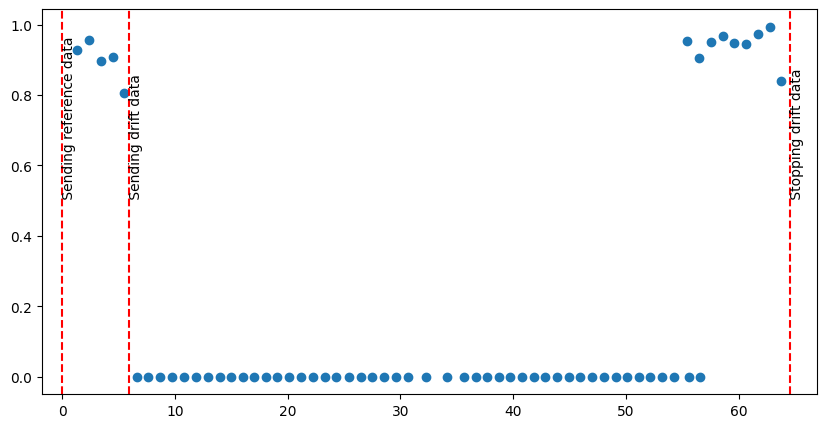

In [67]:
fig = plt.figure(figsize=(10, 5))

ax = fig.gca()

plt.scatter(df_drift_deploy["timestamp"], df_drift_deploy["p_value"], label="Drift Deploy")

for index, row in df_controller.iterrows():
    #if operator is not present in log
    if "operator" not in row["log"] and "Stopping reference data" not in row["log"]:
        ax.axvline(row["timestamp"], color="red", linestyle="--", label="Controller")
        ax.text(row["timestamp"], 0.5, row["log"], rotation=90)

